In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/voice.csv")
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,0.200836,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,0.013683,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,0.008006,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,0.212202,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


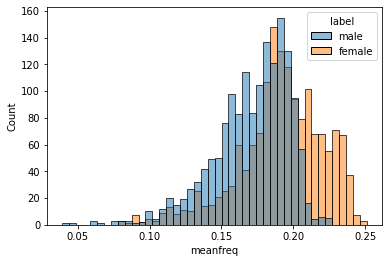

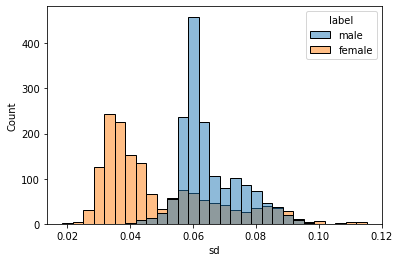

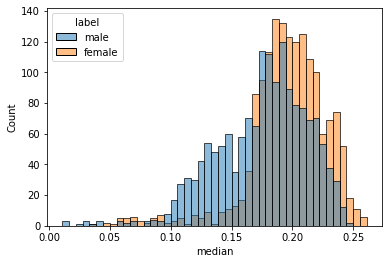

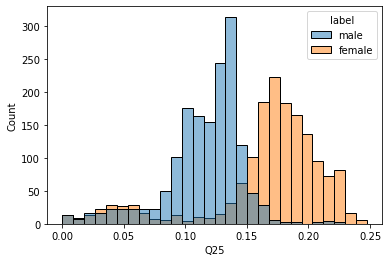

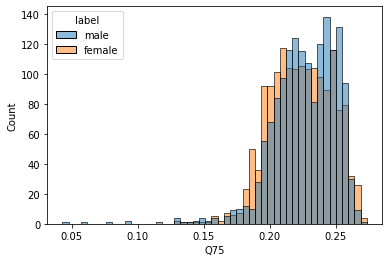

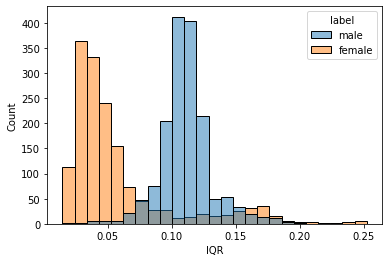

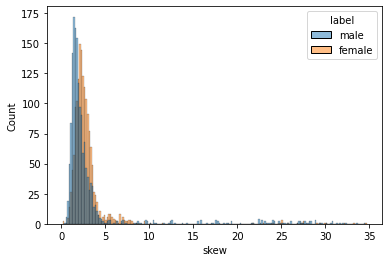

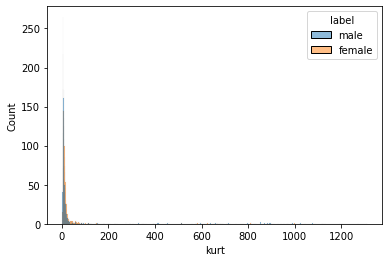

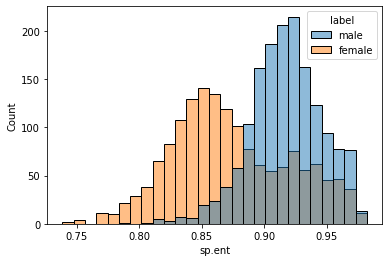

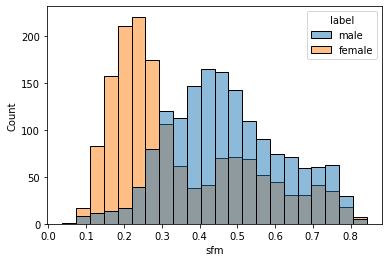

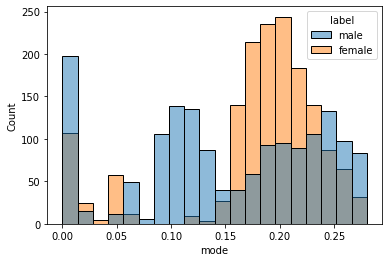

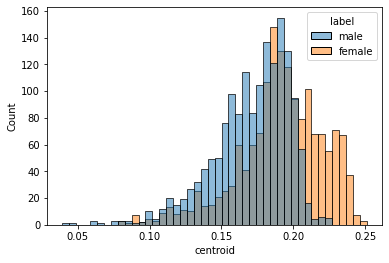

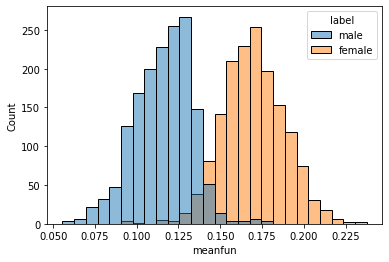

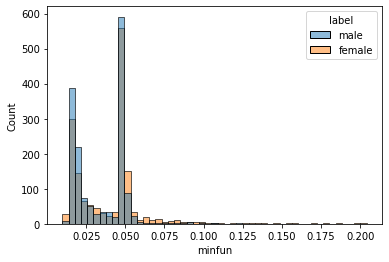

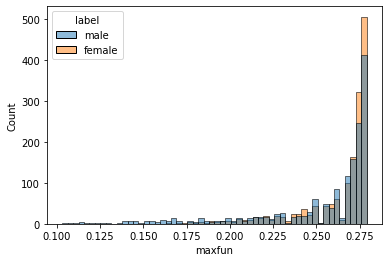

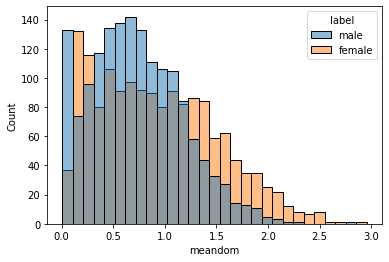

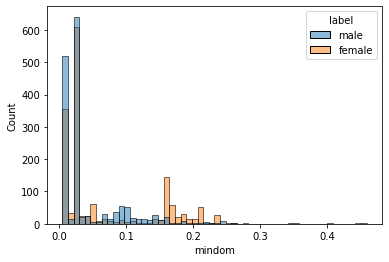

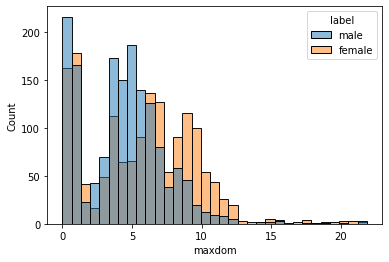

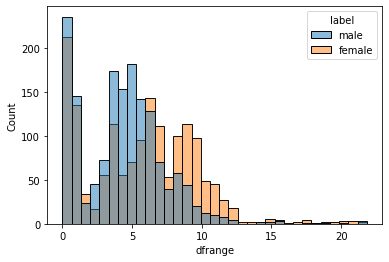

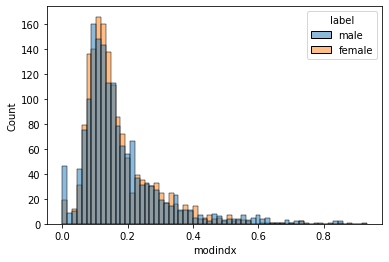

In [ ]:
temp = list(df.columns)
temp.remove('label')

for col in temp:
  sns.histplot(data = df, x =col, hue = 'label')
  plt.show()

In [ ]:
clean_up = {"label" : {"male":1 , "female" : 0}}
df_new = df.replace(clean_up)
df_male = df[df['label']==0]
df_female = df[df['label']==1]

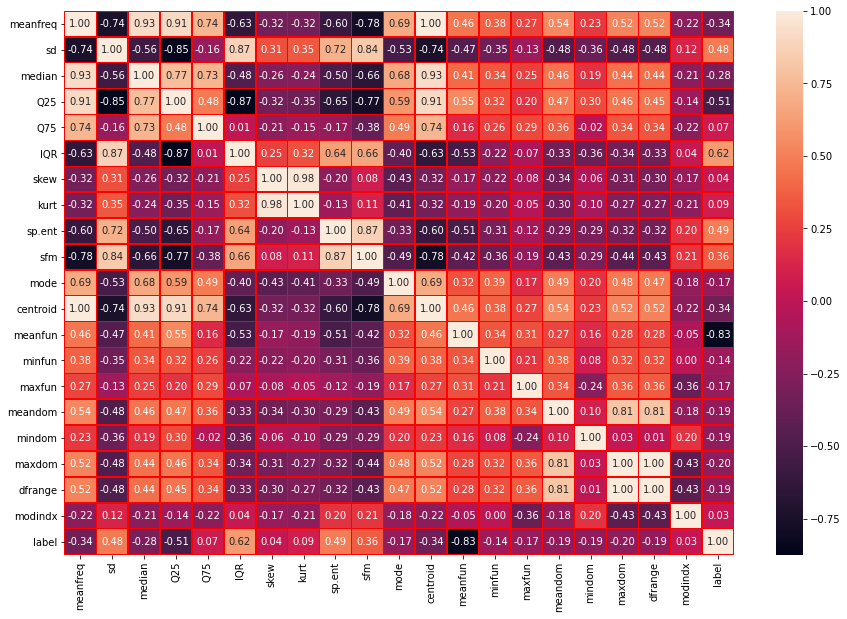

In [ ]:
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_new.corr(), annot=True, linewidths=0.5, linecolor="red", fmt= '.2f',ax=ax)
plt.show()

In [ ]:
meanfun_data = df_new[['label', 'meanfun']]
meanfun_data['freq'] = meanfun_data['meanfun'] * 1000
# meanfun_data['freq'].max()

meanfun_data['freq_BINNED'] = pd.cut(meanfun_data['freq'], bins = np.linspace(55, 235, num = 10))
freq_groups  = meanfun_data.groupby('freq_BINNED').mean()
freq_groups

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,label,meanfun,freq
freq_BINNED,,,
"(55.0, 75.0]",1.000000,0.068878,68.878364
"(75.0, 95.0]",0.981707,0.088330,88.329680
"(95.0, 115.0]",0.996226,0.106004,106.004263
"(115.0, 135.0]",0.957823,0.125064,125.064489
"(135.0, 155.0]",0.343964,0.144918,144.918290
"(155.0, 175.0]",0.016035,0.165392,165.391839
"(175.0, 195.0]",0.008830,0.183804,183.803763
"(195.0, 215.0]",0.000000,0.201824,201.823517
"(215.0, 235.0]",0.000000,0.220104,220.103607


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


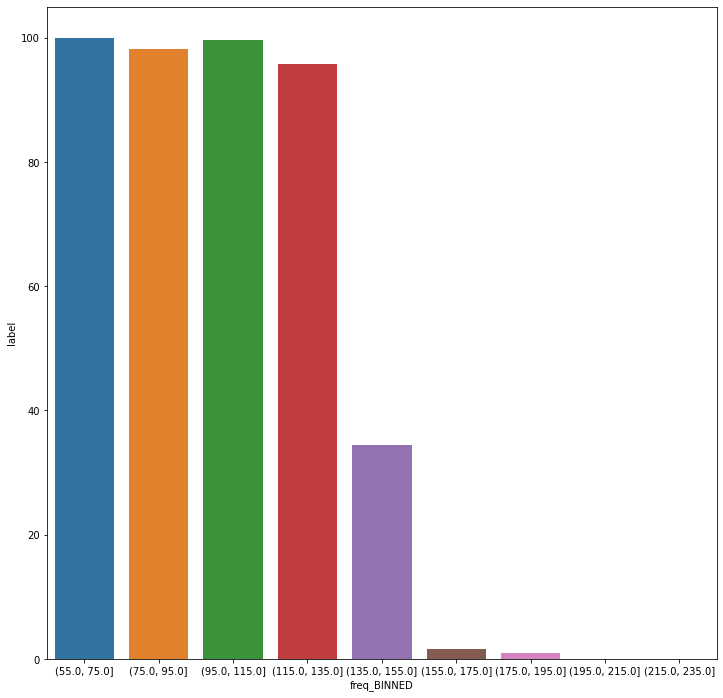

In [ ]:
plt.figure(figsize = (12, 12))
sns.barplot(freq_groups.index.astype(str), 100 * freq_groups['label']);

**Preprocess**

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)                                                             # set random seed so output can be replicated

#df = pd.read_csv("/gdrive/MyDrive/CS419-project/Data/voice.csv")
df = pd.read_csv("/content/voice.csv")
df['label'] = pd.Categorical(df['label'])
df['label'] = df.label.cat.codes                                                  # changing the labels to categorical codes, i.e. 1 and 0 

target = df.pop('label')

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df, target, test_size = 0.2, random_state = 0, stratify = target)
sc = StandardScaler()                                                           
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)        

## **Neural Net**

In [ ]:
def build_model(train_matrix):                                                    # 1 input layer and 2 hidden layers, using BinaryCrossEntropy loss and optimized using Adam optimizer over accuracy
  model = Sequential()
  model.add(tf.keras.Input(shape=(train_matrix.shape[1],)))
  model.add(Dense(32, Activation('relu')))
  model.add(Dense(16, Activation('relu')))
  model.add(Dense(8, Activation('relu')))
  model.add(Dense(1))
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), optimizer='Adam', metrics = ['accuracy'])
  return model

NN_model = build_model(x_train)                                                         

epoch = 500
batchsize = 32
callback = EarlyStopping(monitor= 'loss', patience= 25)                           # added early stopping criteria
hist = NN_model.fit(x_train, y_train, epochs = epoch, batch_size = batchsize, validation_split= 0.2, callbacks = [callback])

Epoch 1/500
64/64 [==============================] - 1s 10ms/step - loss: 0.6286 - accuracy: 0.5672 - val_loss: 0.3819 - val_accuracy: 0.8442
Epoch 2/500
64/64 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.9154 - val_loss: 0.1539 - val_accuracy: 0.9606
Epoch 3/500
64/64 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.9686 - val_loss: 0.0972 - val_accuracy: 0.9744
Epoch 4/500
64/64 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9744 - val_loss: 0.0848 - val_accuracy: 0.9763
Epoch 5/500
64/64 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.9764 - val_loss: 0.0757 - val_accuracy: 0.9763
Epoch 6/500
64/64 [==============================] - 0s 3ms/step - loss: 0.0490 - accuracy: 0.9824 - val_loss: 0.0771 - val_accuracy: 0.9763
Epoch 7/500
64/64 [==============================] - 0s 3ms/step - loss: 0.0595 - accuracy: 0.9780 - val_loss: 0.0760 - val_accuracy: 0.9803
Epoch 8/500


In [ ]:
loss, acc = NN_model.evaluate(x_test, y_test)
print(acc)

20/20 [==============================] - 0s 1ms/step - loss: 0.1464 - accuracy: 0.9795
0.9794952869415283


In [ ]:
y_score = NN_model.predict(x_test)
y_pred_nn = [float(value[0] >= 0.5) for value in y_score]

### Evaluation Metrics

In [ ]:
def get_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report)
    return df_classification_report

get_classification_report(y_test, y_pred_nn)

,0,1,accuracy,macro avg,weighted avg
precision,0.977987,0.981013,0.979495,0.979500,0.979500
recall,0.981073,0.977918,0.979495,0.979495,0.979495
f1-score,0.979528,0.979463,0.979495,0.979495,0.979495
support,317.000000,317.000000,0.979495,634.000000,634.000000


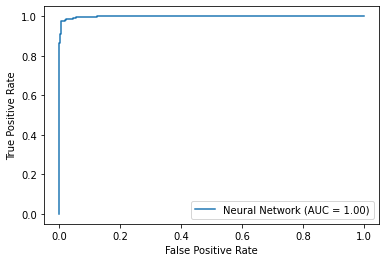

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Neural Network')
display.plot()  
plt.show() 

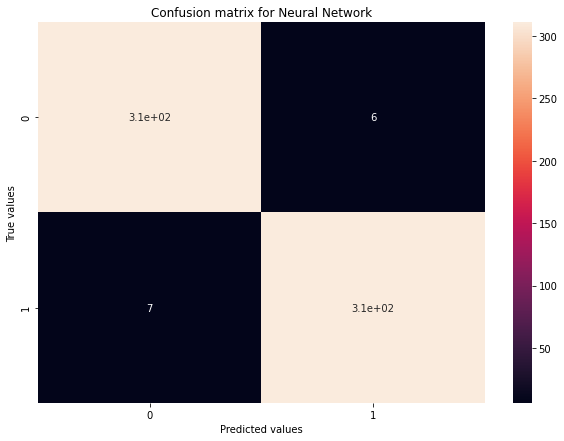

In [ ]:
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(10,7))
sns.heatmap(cm_nn, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix for Neural Network")
plt.show()

## **Naive Bayes**

In [ ]:
nb = GaussianNB()                                                                 # Naive bayes classification 
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred_nb)

print(f"Accuracy on test set: {acc}")
print(f"Accuracy on training set: {metrics.accuracy_score(y_train, nb.predict(x_train))}")

Accuracy on test set: 0.9006309148264984
Accuracy on training set: 0.8898973954222573


In [ ]:
get_classification_report(y_test, y_pred_nb)

,0,1,accuracy,macro avg,weighted avg
precision,0.901899,0.899371,0.900631,0.900635,0.900635
recall,0.899054,0.902208,0.900631,0.900631,0.900631
f1-score,0.900474,0.900787,0.900631,0.900631,0.900631
support,317.000000,317.000000,0.900631,634.000000,634.000000


### Evaluation Metrics

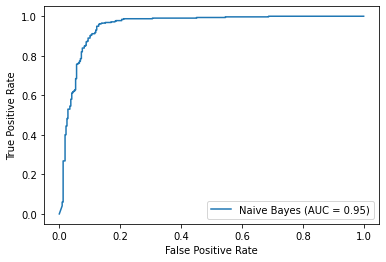

In [ ]:
plot_roc_curve(nb, x_test, y_test, name="Naive Bayes")

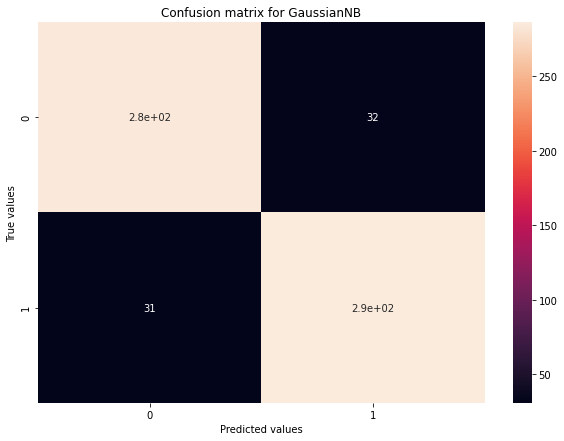

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10,7))
sns.heatmap(cm_nb, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix for GaussianNB")
plt.show()

## **SVM**

In [ ]:
# training a baseline model

clf = SVC()
clf.fit(x_train, y_train);

In [ ]:
print(f"Accuracy on training data: {clf.score(x_train, y_train)}")
print(f"Accuracy on test data: {clf.score(x_test, y_test)}")

Accuracy on training data: 0.9857932123125493
Accuracy on test data: 0.9794952681388013


The high scores indicate that no feature-selection might be required.

#### Hyperparameter tuning

In [ ]:
parameters = [{'kernel':['rbf'], 'gamma':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0], 'C':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]}, 
              {'kernel':['linear'], 'C':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]},
              {'kernel':['poly'], 'degree':[3, 4], 'C':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]}]

print("# Tuning hyper-parameters for accuracy score")
print()

clf = GridSearchCV(
    SVC(), parameters)

clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()

# Tuning hyper-parameters for accuracy score

Best parameters set found on development set:

{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.555 (+/-0.225) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.564 (+/-0.262) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.576 (+/-0.309) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.526 (+/-0.110) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.499 (+/-0.001) for {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'}
0.499 (+/-0.001) for {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'}
0.499 (+/-0.001) for {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'}
0.555 (+/-0.225) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.860 (+/-0.044) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.916 (+/-0.033) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.526 (+/-0.110) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.499 (+/-0.001) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.499 (+/-0.001) for {'C': 0.01, 'gamma': 1

In [ ]:
print("Best parameters:")
print(clf.best_params_, "\n")
print("Best accuracy score on validation set: ")
print(clf.best_score_)

print(f"\n\nAccuracy on test set: {clf.score(x_test, y_test)}")

Best parameters:
{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'} 

Best accuracy score on validation set: 
0.9798730812108738


Accuracy on test set: 0.9763406940063092


In [ ]:
y_pred_svm = clf.predict(x_test)

### Evaluation Metrics

In [ ]:
get_classification_report(y_test, y_pred_svm)

,0,1,accuracy,macro avg,weighted avg
precision,0.974843,0.977848,0.976341,0.976345,0.976345
recall,0.977918,0.974763,0.976341,0.976341,0.976341
f1-score,0.976378,0.976303,0.976341,0.976341,0.976341
support,317.000000,317.000000,0.976341,634.000000,634.000000


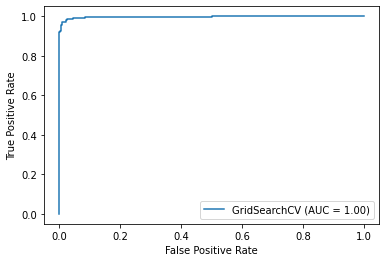

In [ ]:
plot_roc_curve(clf, x_test, y_test)

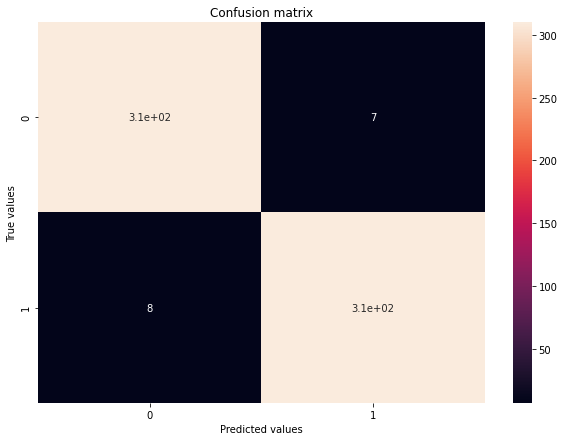

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10,7))
sns.heatmap(cm_svm, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix")
plt.show()

## **XGBoost**

In [ ]:
clf_xgb = xgb.XGBClassifier(n_estimators = 400, objective='binary:logistic', random_state = 0, seed = 42, gamma = 0, learning_rate= 0.1, max_depth = 3, reg_lambda= 0, scale_pos_weight= 1)
clf_xgb.fit(x_train, y_train, verbose = 0, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = [(x_test, y_test)])

y_pred = clf_xgb.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy on training set: {metrics.accuracy_score(y_train, clf_xgb.predict(x_train))}")
print(f"Accuracy on test set: {acc}")

Accuracy on training set: 1.0
Accuracy on test set: 0.9747634069400631


### Hyperparameter tuning

In [ ]:
#################################################### Search For HyperParameters ########################################################

params = [{'max_depth': [3, 4, 5], 'learning_rate': [1,0.1, 0.01], 'gamma': [0, 0.25, 1], 'reg_lambda': [0.1,1,10], 'scale_pos_weight': [1,3,5]}]

grid_search = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators = 200, objective='binary:logistic', random_state = 0, seed = 42, subsample = 0.9, colsample_bytree= 0.5) , param_grid = params, scoring = 'neg_log_loss', cv = 3, n_jobs = -1)
grid_search.fit(x_train, y_train)

grid_search.best_params_
############## END OF ROUND 1 ############################

params = [{'max_depth': [4], 'learning_rate': [0.1], 'gamma': [0], 'reg_lambda': [10, 25, 100], 'scale_pos_weight': [1]}]

grid_search = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators = 200, objective='binary:logistic', random_state = 0, seed = 42, subsample = 0.9, colsample_bytree= 0.5) , param_grid = params, scoring = 'neg_log_loss', cv = 3, n_jobs = -1)
grid_search.fit(x_train, y_train)

grid_search.best_params_
############## END OF ROUND 2 #############################

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10,
 'scale_pos_weight': 1}

### Evaluation Metrics

In [ ]:
y_pred_xgb = grid_search.predict(x_test)

print(f"Accuracy on training set: {metrics.accuracy_score(y_train, grid_search.predict(x_train))}")
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred_xgb)}")

Accuracy on training set: 0.9984214680347278
Accuracy on test set: 0.9794952681388013


In [ ]:
get_classification_report(y_test, y_pred_xgb)

,0,1,accuracy,macro avg,weighted avg
precision,0.981013,0.977987,0.979495,0.979500,0.979500
recall,0.977918,0.981073,0.979495,0.979495,0.979495
f1-score,0.979463,0.979528,0.979495,0.979495,0.979495
support,317.000000,317.000000,0.979495,634.000000,634.000000


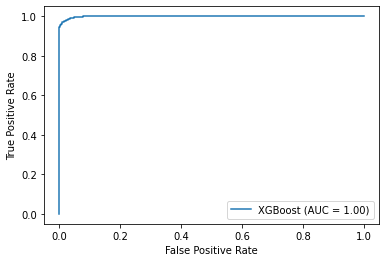

In [ ]:
plot_roc_curve(grid_search, x_test, y_test, name="XGBoost")

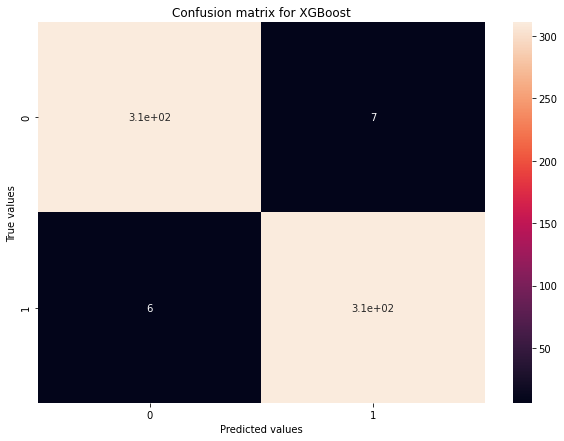

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix for XGBoost")
plt.show()

## **RFC**

In [ ]:
rfm = RandomForestClassifier(n_estimators = 100, n_jobs = -1, bootstrap = False, max_features = 'auto', max_depth = None, min_samples_leaf = 2, random_state= 0)
rfm.fit(x_train, y_train)
y_pred = rfm.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy on training set: {metrics.accuracy_score(y_train, rfm.predict(x_train))}")
print(f"Accuracy on test set: {acc}")

Accuracy on training set: 1.0
Accuracy on test set: 0.9747634069400631


### Hyperparameter tuning

In [ ]:
#################################################### Search For HyperParameters ########################################################

est = RandomForestClassifier(n_jobs = -1)

params = [{'n_estimators': [1, 10, 100], 'min_samples_leaf': [2], 'max_depth': [None], 'criterion': ['gini'], 'bootstrap': [True, False]}]

rfc_best = RandomizedSearchCV(estimator = est, param_distributions = params, scoring = 'accuracy', cv = 5, n_iter = 5, n_jobs = -1)
rfc_best.fit(x_train, y_train)

rfc_best.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [ ]:
y_pred_rfc = rfc_best.predict(x_test)

print(f"Accuracy on training set: {rfc_best.best_score_}")
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, y_pred_rfc)}")

Accuracy on training set: 0.9794801630922032
Accuracy on test set: 0.9716088328075709


### Evaluation Metrics

In [ ]:
get_classification_report(y_test, y_pred_rfc)

,0,1,accuracy,macro avg,weighted avg
precision,0.977987,0.981013,0.979495,0.979500,0.979500
recall,0.981073,0.977918,0.979495,0.979495,0.979495
f1-score,0.979528,0.979463,0.979495,0.979495,0.979495
support,317.000000,317.000000,0.979495,634.000000,634.000000


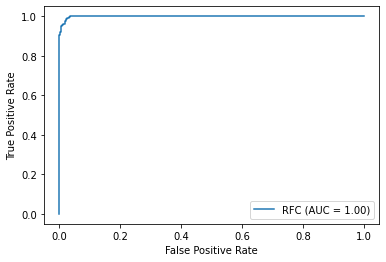

In [ ]:
plot_roc_curve(rfc_best, x_test, y_test, name="RFC")

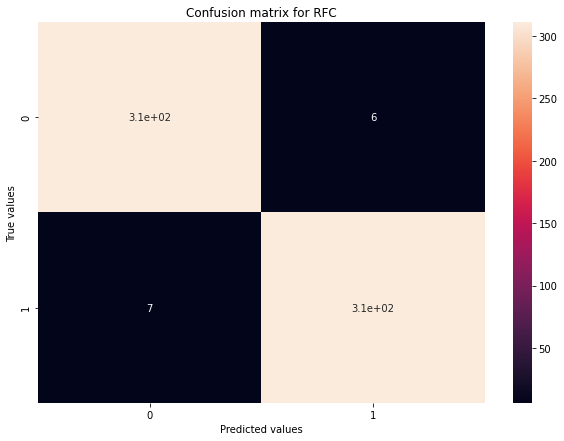

In [ ]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rfc, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix for RFC")
plt.show()

## **Logistic Regression**

In [ ]:
param_grid_LR = {
    'penalty' : ['l1','l2'],
    'C' : np.linspace(0.1,2,10)
}

In [ ]:
LR_model = LogisticRegression(max_iter=5000, n_jobs = -1)
clf_LR = GridSearchCV(LR_model,param_grid = param_grid_LR, n_jobs = -1, scoring='accuracy', refit = True)
clf_LR.fit(x_train,y_train)
results = pd.DataFrame(clf_LR.cv_results_)

In [ ]:
print(clf_LR.best_estimator_)
print(clf_LR.best_score_)

LogisticRegression(C=0.3111111111111111, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.972770150696572


In [ ]:
y_train_pred_Lr = clf_LR.predict(x_train)
y_test_pred_LR = clf_LR.predict(x_test)

In [ ]:
LR_score2 = metrics.accuracy_score(y_train, y_train_pred_Lr)
LR_score = metrics.accuracy_score(y_test, y_test_pred_LR)
print(f"Accuracy on test set: {LR_score}")
print(f"Accuracy on train set: {LR_score2}")

Accuracy on test set: 0.9700315457413249
Accuracy on train set: 0.9759273875295975


### Evaluation Metrics

In [ ]:
get_classification_report(y_test, y_test_pred_LR)

,0,1,accuracy,macro avg,weighted avg
precision,0.965625,0.974522,0.970032,0.970074,0.970074
recall,0.974763,0.965300,0.970032,0.970032,0.970032
f1-score,0.970173,0.969889,0.970032,0.970031,0.970031
support,317.000000,317.000000,0.970032,634.000000,634.000000


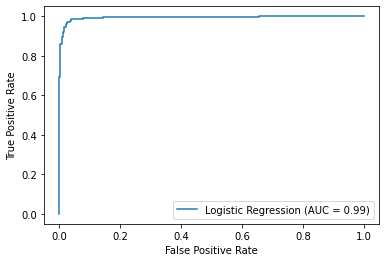

In [ ]:
plot_roc_curve(clf_LR, x_test, y_test, name="Logistic Regression")

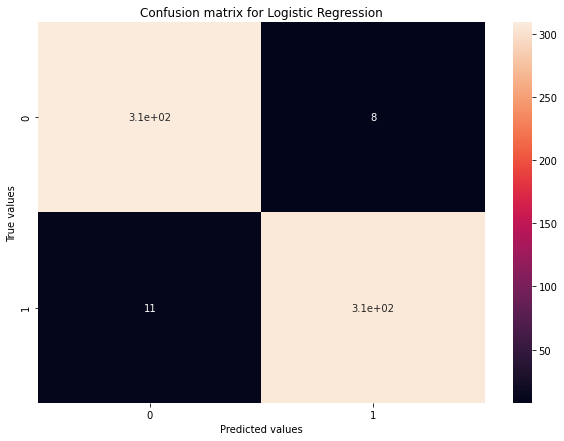

In [ ]:
cm_lr = confusion_matrix(y_test, y_test_pred_LR)

plt.figure(figsize=(10,7))
sns.heatmap(cm_lr, annot=True)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Confusion matrix for Logistic Regression")
plt.show()